<a href="https://colab.research.google.com/github/rudycav/Digital-Assets-Prediction-Model/blob/main/Project/%20Crypto_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import requests
import pandas as pd
import matplotlib.pylab as plt
#%matplotlib widget
#from google.colab import output
#output.enable_custom_widget_manager()

from datetime import datetime
from datetime import datetime, timedelta
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LinearRegression
from scipy.stats import sem

In [100]:
#Set cryptocurrency ticker
symbol = 'ETH'

def get_crypto_price(symbol, exchange, start_date = None):
    api_key = ' '
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    df.index.names = ['Date']
 

    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    #Drop irrelevant columns
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)

    if start_date:
        df = df[df.index >= start_date]
    return df

crypto_df = get_crypto_price(symbol = symbol, exchange = 'USD', start_date = '2015-05-01')
crypto_df.head()

,open,high,low,close,volume
Date,,,,,
2020-02-06,203.78,216.33,201.02,213.19,608240.22330
2020-02-07,213.16,225.00,213.14,223.33,629361.15466
2020-02-08,223.36,227.75,213.22,223.05,548551.87465
2020-02-09,223.01,230.65,222.86,228.49,350336.24399
2020-02-10,228.53,229.40,216.37,222.89,510415.49949


In [101]:
#Set the number of unforseen days ahead to predict
forecast_days = 14

def create_prediction_column(df):
  crypto_df['forecast'] = crypto_df[['high']].shift(-forecast_days)

  return crypto_df

prediction_column = create_prediction_column(crypto_df)
prediction_column.tail()

,open,high,low,close,volume,forecast
Date,,,,,,
2022-10-28,1514.04,1574.90,1479.82,1554.41,858954.4425,NaN
2022-10-29,1554.40,1663.06,1547.66,1619.55,914161.0846,NaN
2022-10-30,1619.55,1640.06,1576.56,1590.44,476036.4243,NaN
2022-10-31,1590.45,1635.80,1545.43,1572.69,810334.2414,NaN
2022-11-01,1572.69,1576.46,1568.80,1570.51,14383.1698,NaN


In [102]:
#Exponential weighted mean to produce float numbers for a more accurate focus in the daily candles
def smooth_data(data, alpha):

    return data.ewm(alpha=alpha).mean()

expo_smooth = smooth_data(prediction_column, 0.65)


In [103]:
expo_smooth.head()

,open,high,low,close,volume,forecast
Date,,,,,,
2020-02-06,203.780000,216.330000,201.020000,213.190000,608240.223300,264.330000
2020-02-07,210.728148,222.752222,209.997778,220.701111,623885.357641,267.226296
2020-02-08,219.306655,226.146299,212.186044,222.296282,572725.097545,266.943582
2020-02-09,221.750502,229.118303,219.229816,226.383533,425970.100561,272.708768
2020-02-10,226.180443,229.302373,217.361121,224.100747,481149.422007,275.643482


In [104]:
def create_dataset(df):
  #Create independent data for daily highs
  independent_dataset = np.array(prediction_column.high)
  independent_dataset = independent_dataset[:-forecast_days]

  #Create dependent data for the forecast column
  dependent_dataset = prediction_column.forecast.values
  dependent_dataset = dependent_dataset[:-forecast_days]

  return independent_dataset, dependent_dataset

x_dataset, y_dataset = create_dataset(expo_smooth)

In [105]:
x_dataset.shape

(986,)

In [106]:
y_dataset.shape

(986,)

In [107]:
#Split between training and testing data
def split_data(X_data, y_data, test_size):
  X_train, X_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size = 0.3)

  return X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test

X_train, X_test, y_train, y_test = split_data(x_dataset, y_dataset, test_size=0.3)

In [108]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((690, 1), (296, 1), (690,), (296,))

In [109]:
def regression_model(X_train, y_train, X_test, y_test):
  #Linear regression is the classificaion model of choice
  lin_reg_model = LinearRegression()
  lin_reg_model.fit(X_train, y_train)

  score_acc = lin_reg_model.score(X_test, y_test)
  score_acc = round(score_acc,2)
  score_acc

  return lin_reg_model, score_acc

linear_regression_model, accuracy_score = regression_model(X_train, y_train, X_test, y_test)

In [110]:
print(f'Model accuracy score: {accuracy_score}')

Model accuracy score: 0.91


In [111]:
def model_results(df):
  actual_price = np.array(crypto_df[['high']])
  #Create model prediction based on previous highs
  model_predictions = linear_regression_model.predict(actual_price)

  model_predictions_df = pd.DataFrame(model_predictions, columns=['Model Results'])
  model_predictions_df.index.name = 'Date'
  model_predictions_df.index = crypto_df.index

  return model_predictions_df

model_predictions_df = (model_results(crypto_df))


In [112]:
model_predictions_df.head()

,Model Results
Date,
2020-02-06,315.288257
2020-02-07,323.454739
2020-02-08,326.045031
2020-02-09,328.776611
2020-02-10,327.599206


In [113]:
def create_prediction(df):
  #Predict future highs 
  actual_price = np.array(crypto_df[['high']])[-forecast_days:]
  forecast_prediction = linear_regression_model.predict(actual_price)

  return forecast_prediction

forecast_prediction = (create_prediction(crypto_df))


In [114]:
forecast_prediction

array([1348.73922942, 1346.26196878, 1342.5884644 , 1355.05012155,
       1403.41792915, 1402.52310116, 1548.10690528, 1613.88147206,
       1598.42449597, 1594.95821492, 1677.99825226, 1656.33399569,
       1652.32139861, 1596.42761667])

In [115]:
#Set datetime format for future dates
def get_future_dates(datetime):
  future_dates = []

  datetime = datetime

  for i in range(forecast_days): 
    datetime += timedelta(days=1)
    future_dates.append(datetime.strftime('%Y-%m-%d'))

  return future_dates

future_dates = get_future_dates(datetime.now())

In [116]:
#Set index to datetime format
def datetime_index(forecast_df, crypto_df):

  forecast_df = pd.DataFrame(forecast_prediction, columns=['forecast'])
  forecast_df['Date'] = future_dates
  forecast_df.set_index('Date', inplace=True)
  forecast_df.index = pd.to_datetime(forecast_df.index)
  crypto_df.index = pd.to_datetime(crypto_df.index)

  return forecast_df, crypto_df

forecast_df, crypto_df = datetime_index(future_dates, crypto_df)

In [117]:
print(forecast_df.head())

               forecast
Date                   
2022-11-02  1348.739229
2022-11-03  1346.261969
2022-11-04  1342.588464
2022-11-05  1355.050122
2022-11-06  1403.417929


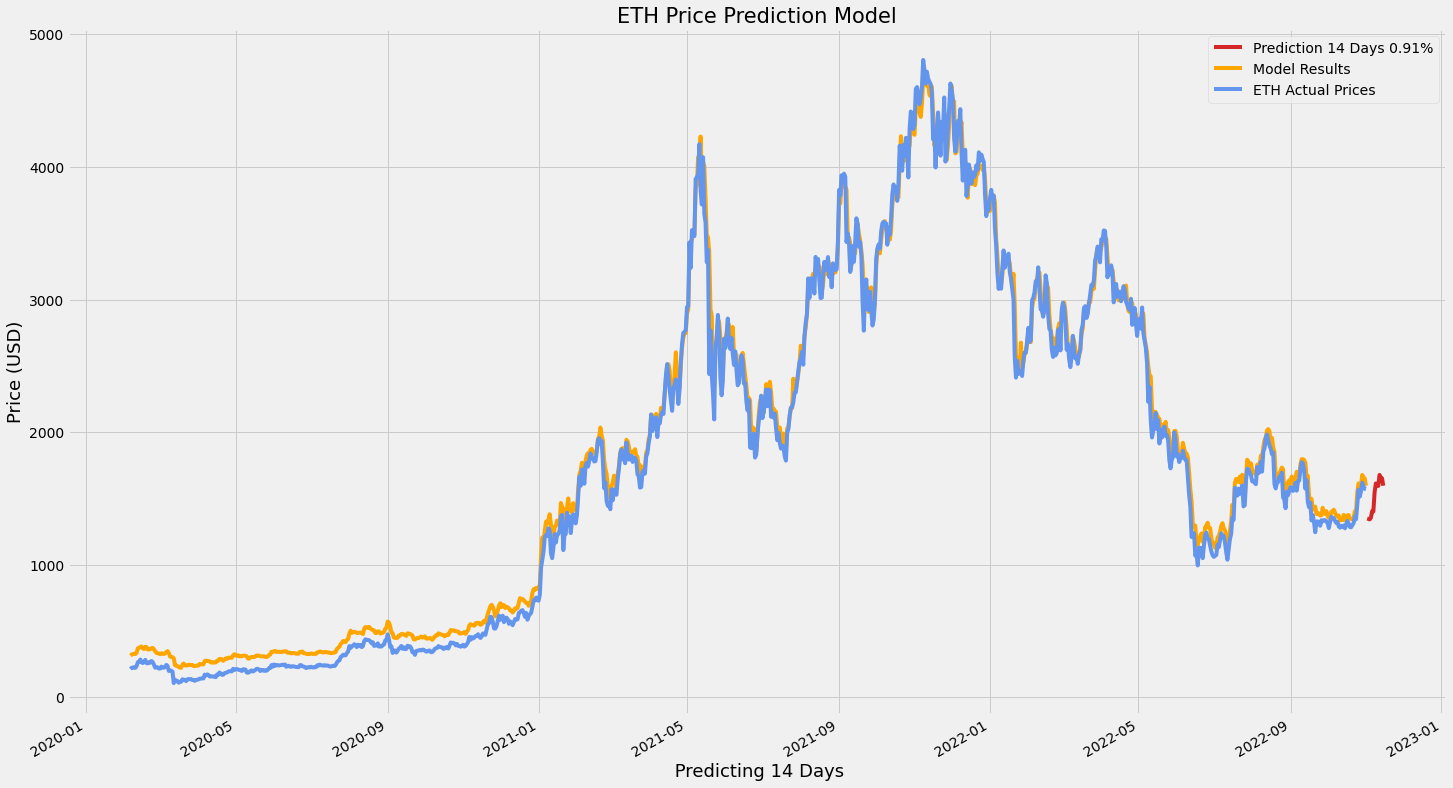

<module 'matplotlib.pylab' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pylab.py'>

In [118]:
import matplotlib.dates as mdates

def plot_model():
  plt.figure(figsize=(22,14))
  plt.plot(forecast_df.forecast, color='tab:red', label = f'Prediction {forecast_days} Days {accuracy_score}%')
  plt.plot(model_predictions_df, color='orange', label = 'Model Results')
  plt.plot(crypto_df.close, color='cornflowerblue', label = f'{symbol} Actual Prices')
  plt.title(f'{symbol} Price Prediction Model', fontsize=21)
  plt.xlabel(f' Predicting {forecast_days} Days', fontsize=18)
  plt.ylabel('Price (USD)', fontsize=18)
  plt.legend(loc='upper right')
  plt.gcf().autofmt_xdate()

  plt.show()

  return plt

plot_model()

In [119]:
#Dateframe columns for future predictions based on n forecast days
forecast_df.style.background_gradient(axis=None, low=0.75, high=2)

,forecast
Date,
2022-11-02 00:00:00,1348.739229
2022-11-03 00:00:00,1346.261969
2022-11-04 00:00:00,1342.588464
2022-11-05 00:00:00,1355.050122
2022-11-06 00:00:00,1403.417929
2022-11-07 00:00:00,1402.523101
2022-11-08 00:00:00,1548.106905
2022-11-09 00:00:00,1613.881472
2022-11-10 00:00:00,1598.424496
